## Check the GPU

In [1]:
!nvidia-smi

Mon Jun  8 12:31:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Libraries

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import os
import time
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(101)

# tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K

# tensorflow.contrib.training is deprecated
# from tensorflow.contrib.training import HParams

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Add, Softmax, GlobalMaxPool2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Input, ReLU, Lambda, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

# Renewed Batch Norm
# Adding all the code in the python file directly in the notebook
# from batchnorm import *

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

# One Cycle LR'
# Adding all the code in the python file directly in the notebook
# from clr import OneCycleLR, LRFinder

# clr.py

In [0]:
!cp "/content/drive/My Drive/BatchNorm Research/Utils/clr.py" .
from clr import *

# Downloading Dataset

In [6]:
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


# View Data

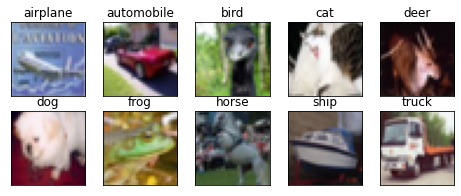

In [7]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Setting Hyperparams

In [0]:
# Dictionary of hyperparameters
hparams = {
    'learning_rate' : 0.4,  # fixed learning rate
    'batch_size': 512,  # training batch size
    'momentum' : 0.9, # fixed momentum
    'n_epochs': 24,  # number of epochs to train
    'decay' : 1e-04, # learning rate*batch size
}

# Image Normalization and One hot encoding

In [0]:
#Image Normalization
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')

mean = np.mean(train_features, axis=(0,1,2))
std = np.std(train_features, axis=(0,1,2))
X_train = (train_features - mean) / (std)
X_test = (test_features - mean) / (std)

# convert class labels to binary class labels
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

# Image Augmentation techniques

* Random Crop of 32x32 with padding of 4px
* Horizontal Flip
* CutOut of 8x8


In [0]:
# Custom Image augmentation 

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

datagen = ImageDataGenerator(preprocessing_function=CustomImageDataGen)
datagen.fit(X_train)

# Modified BatchNorm function

In [0]:
!cp "/content/drive/My Drive/BatchNorm Research/Utils/MBatchNorm.py" .
from MBatchNorm import *

# 1. Model with Modified Batch Normalization Stride 1 - 30 epochs

## Network Architecture (ResNet 9)

In [0]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
def Resnet9(input_dim, n_classes): 
    inputs = Input(shape= input_dim, name='input')

    # Define the repeated conv_bn_relu function
    def conv_bn_relu(x, layer_name, pool=False):
        channels = {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 256}
        x = Conv2D(filters = channels[layer_name], 
                   kernel_size = 3, 
                   strides = 1, 
                   padding = 'same',
                   kernel_initializer=init_pytorch,
                   kernel_regularizer=l2(hparams['decay']),
                   use_bias=False)(x)
        # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        # Applying MODIFIED Batch Normalization with stride 1
        x = BatchNorm()(x)
        x = ReLU()(x)
        if pool==True:
            x = MaxPooling2D(2)(x)
        return x        

    # Stack the layers
    # Layer Prep
    layer_prep = conv_bn_relu(inputs, 'prep')

    # Layer 1
    layer1_part1 = conv_bn_relu(layer_prep, 'layer1', pool=True)  
    layer1_part2_res1 = conv_bn_relu(layer1_part1, 'layer1')
    layer1_part2_res2 = conv_bn_relu(layer1_part2_res1, 'layer1')
    layer1 = Add()([layer1_part1, layer1_part2_res2])
    
    # Layer 2
    layer2_part1 = conv_bn_relu(layer1, 'layer2', pool=True)  
    layer2_part2_res1 = conv_bn_relu(layer2_part1, 'layer2')
    layer2_part2_res2 = conv_bn_relu(layer2_part2_res1, 'layer2')
    layer2 = Add()([layer2_part1, layer2_part2_res2])

    # Layer 3
    layer3 = conv_bn_relu(layer2, 'layer3', pool=True)

    # Layer Classifier
    layer_classifier = GlobalMaxPool2D()(layer3)
    layer_classifier = Flatten()(layer_classifier)
    layer_classifier = Dense(n_classes, kernel_initializer= init_pytorch,
                           kernel_regularizer=l2(hparams['decay']),
                           use_bias=False, name='classifier')(layer_classifier)
    layer_classifier = Lambda(lambda x : x * 0.2)(layer_classifier)

    outputs = Softmax()(layer_classifier)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr= hparams['learning_rate'], momentum= hparams['momentum'], 
                              nesterov=True),
                metrics=['accuracy'])
    return model

In [14]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_norm (BatchNorm)          (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_norm[0][0]                 
______________________________________________________________________________________________

## Model Training

In [15]:
!pip install -U tensorboard-plugin-profile

     |████████████████████████████████| 1.1MB 9.0MB/s 


In [16]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel_MBN_S1.h5", verbose=0, 
                               save_best_only=True, monitor="val_accuracy")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams['learning_rate'],
                        batch_size = hparams['batch_size'],
                        samples = len(X_train),
                        epochs = hparams['n_epochs'],
                        maximum_momentum = hparams['momentum'],
                        verbose=False)

log_dir = "logs/fit/MBN_S1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1,
                                                      profile_batch = '49')

# Fit the model
history = net.fit(datagen.flow(X_train, y_train, 
                  batch_size= hparams['batch_size'], 
                  shuffle=True),
                  epochs = hparams['n_epochs'], 
                  steps_per_epoch= np.ceil(X_train.shape[0]/hparams['batch_size']),
                  validation_data=(X_test, y_test),
                  callbacks = [lr_manager, checkpointer, tensorboard_callback])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 13s 128ms/step - loss: 1.4783 - accuracy: 0.4873 - val_loss: 2.0864 - val_accuracy: 0.2444
Epoch 2/24
98/98 [==============================] - 12s 118ms/step - loss: 0.8694 - accuracy: 0.7153 - val_loss: 1.2317 - val_accuracy: 0.6258
Epoch 3/24
98/98 [==============================] - 12s 118ms/step - loss: 0.6819 - accuracy: 0.7865 - val_loss: 1.4155 - val_accuracy: 0.5883
Epoch 4/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5880 - accuracy: 0.8228 - val_loss: 0.8558 - val_accuracy: 0.7386
Epoch 5/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5419 - accuracy: 0.8429 - val_loss: 0.7374 - val_accuracy: 0.7797
Epoch 6/24
98/98 [==============================] - 12s 117ms/step - loss: 0.5074 - accuracy: 0.8571 - val_loss: 1.0770 - val_accuracy: 0.7212
Epoch 7/24
98/98 [==============================] - 12s 118ms/step - loss: 0.4816 - accuracy: 0.8716 - val_loss: 0.6773 - val_accuracy: 0.8163

## Model Evaluation

In [17]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel_MBN_S1.h5", custom_objects={'init_pytorch': init_pytorch,
                                                              'BatchNorm': BatchNorm})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams['batch_size'], verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

20/20 [==============================] - 1s 37ms/step - loss: 0.3633 - accuracy: 0.9338
Minimal Validation Loss :  0.3632766604423523
Max Validation Accuracy: 93.37999820709229 %


## Tensorboard

In [0]:
%tensorboard --logdir 'logs/fit/MBN_S1/'

## Plot Loss and Accuracy History

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


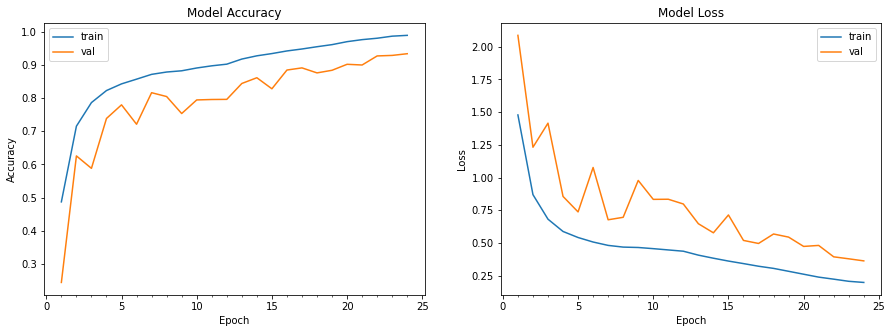

In [19]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# plot model history
plot_model_history(history)

# 2. Model with Modified Batch Normalization Stride 2 - 30 epochs

## Network Architecture (ResNet 9)

In [0]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
def Resnet9(input_dim, n_classes): 
    inputs = Input(shape= input_dim, name='input')

    # Define the repeated conv_bn_relu function
    def conv_bn_relu(x, layer_name, pool=False):
        channels = {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 256}
        x = Conv2D(filters = channels[layer_name], 
                   kernel_size = 3, 
                   strides = 1, 
                   padding = 'same',
                   kernel_initializer=init_pytorch,
                   kernel_regularizer=l2(hparams['decay']),
                   use_bias=False)(x)
        # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        # Applying MODIFIED Batch Normalization with stride 2
        x = BatchNorm(stride=2)(x)
        x = ReLU()(x)
        if pool==True:
            x = MaxPooling2D(2)(x)
        return x        

    # Stack the layers
    # Layer Prep
    layer_prep = conv_bn_relu(inputs, 'prep')

    # Layer 1
    layer1_part1 = conv_bn_relu(layer_prep, 'layer1', pool=True)  
    layer1_part2_res1 = conv_bn_relu(layer1_part1, 'layer1')
    layer1_part2_res2 = conv_bn_relu(layer1_part2_res1, 'layer1')
    layer1 = Add()([layer1_part1, layer1_part2_res2])
    
    # Layer 2
    layer2_part1 = conv_bn_relu(layer1, 'layer2', pool=True)  
    layer2_part2_res1 = conv_bn_relu(layer2_part1, 'layer2')
    layer2_part2_res2 = conv_bn_relu(layer2_part2_res1, 'layer2')
    layer2 = Add()([layer2_part1, layer2_part2_res2])

    # Layer 3
    layer3 = conv_bn_relu(layer2, 'layer3', pool=True)

    # Layer Classifier
    layer_classifier = GlobalMaxPool2D()(layer3)
    layer_classifier = Flatten()(layer_classifier)
    layer_classifier = Dense(n_classes, kernel_initializer= init_pytorch,
                           kernel_regularizer=l2(hparams['decay']),
                           use_bias=False, name='classifier')(layer_classifier)
    layer_classifier = Lambda(lambda x : x * 0.2)(layer_classifier)

    outputs = Softmax()(layer_classifier)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr= hparams['learning_rate'], momentum= hparams['momentum'], 
                              nesterov=True),
                metrics=['accuracy'])
    return model

In [26]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_norm_16 (BatchNorm)       (None, 32, 32, 64)   256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
re_lu_16 (ReLU)                 (None, 32, 32, 64)   0           batch_norm_16[0][0]              
____________________________________________________________________________________________

## Model Training

In [27]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel_MBN_S2.h5", verbose=0, 
                               save_best_only=True, monitor="val_accuracy")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams['learning_rate'],
                        batch_size = hparams['batch_size'],
                        samples = len(X_train),
                        epochs = hparams['n_epochs'],
                        maximum_momentum = hparams['momentum'],
                        verbose=False)

log_dir = "logs/fit/MBN_S2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1,
                                                      profile_batch = '49')

# Fit the model
history = net.fit(datagen.flow(X_train, y_train, 
                  batch_size= hparams['batch_size'], 
                  shuffle=True),
                  epochs = hparams['n_epochs'], 
                  steps_per_epoch= np.ceil(X_train.shape[0]/hparams['batch_size']),
                  validation_data=(X_test, y_test),
                  callbacks = [lr_manager, checkpointer, tensorboard_callback])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 12s 122ms/step - loss: 1.4811 - accuracy: 0.4901 - val_loss: 2.0147 - val_accuracy: 0.2660
Epoch 2/24
98/98 [==============================] - 12s 119ms/step - loss: 0.8710 - accuracy: 0.7148 - val_loss: 1.2388 - val_accuracy: 0.5926
Epoch 3/24
98/98 [==============================] - 12s 118ms/step - loss: 0.6866 - accuracy: 0.7846 - val_loss: 1.4006 - val_accuracy: 0.5916
Epoch 4/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5897 - accuracy: 0.8229 - val_loss: 0.7741 - val_accuracy: 0.7806
Epoch 5/24
98/98 [==============================] - 11s 117ms/step - loss: 0.5424 - accuracy: 0.8419 - val_loss: 0.8350 - val_accuracy: 0.7583
Epoch 6/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5076 - accuracy: 0.8567 - val_loss: 0.7876 - val_accuracy: 0.7818
Epoch 7/24
98/98 [==============================] - 11s 117ms/step - loss: 0.4865 - accuracy: 0.8687 - val_loss: 0.8679 - val_accuracy: 0.7619

## Model Evaluation

In [28]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel_MBN_S2.h5", custom_objects={'init_pytorch': init_pytorch,
                                                              'BatchNorm': BatchNorm})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams['batch_size'], verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

20/20 [==============================] - 1s 29ms/step - loss: 0.3681 - accuracy: 0.9344
Minimal Validation Loss :  0.36810579895973206
Max Validation Accuracy: 93.44000220298767 %


## Tensorboard

In [0]:
%tensorboard --logdir logs/fit/MBN_S2/

## Plot Loss and Accuracy History

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


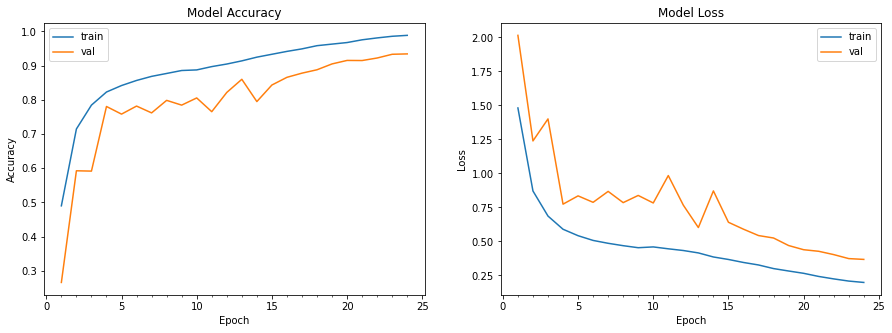

In [30]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# plot model history
plot_model_history(history)

# 3. Model with Modified Batch Normalization Stride 4 - 30 epochs

## Network Architecture (ResNet 9)

In [0]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
def Resnet9(input_dim, n_classes): 
    inputs = Input(shape= input_dim, name='input')

    # Define the repeated conv_bn_relu function
    def conv_bn_relu(x, layer_name, pool=False):
        channels = {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 256}
        x = Conv2D(filters = channels[layer_name], 
                   kernel_size = 3, 
                   strides = 1, 
                   padding = 'same',
                   kernel_initializer=init_pytorch,
                   kernel_regularizer=l2(hparams['decay']),
                   use_bias=False)(x)
        # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        # Applying MODIFIED Batch Normalization with stride 4
        x = BatchNorm(stride=4)(x)
        x = ReLU()(x)
        if pool==True:
            x = MaxPooling2D(2)(x)
        return x        

    # Stack the layers
    # Layer Prep
    layer_prep = conv_bn_relu(inputs, 'prep')

    # Layer 1
    layer1_part1 = conv_bn_relu(layer_prep, 'layer1', pool=True)  
    layer1_part2_res1 = conv_bn_relu(layer1_part1, 'layer1')
    layer1_part2_res2 = conv_bn_relu(layer1_part2_res1, 'layer1')
    layer1 = Add()([layer1_part1, layer1_part2_res2])
    
    # Layer 2
    layer2_part1 = conv_bn_relu(layer1, 'layer2', pool=True)  
    layer2_part2_res1 = conv_bn_relu(layer2_part1, 'layer2')
    layer2_part2_res2 = conv_bn_relu(layer2_part2_res1, 'layer2')
    layer2 = Add()([layer2_part1, layer2_part2_res2])

    # Layer 3
    layer3 = conv_bn_relu(layer2, 'layer3', pool=True)

    # Layer Classifier
    layer_classifier = GlobalMaxPool2D()(layer3)
    layer_classifier = Flatten()(layer_classifier)
    layer_classifier = Dense(n_classes, kernel_initializer= init_pytorch,
                           kernel_regularizer=l2(hparams['decay']),
                           use_bias=False, name='classifier')(layer_classifier)
    layer_classifier = Lambda(lambda x : x * 0.2)(layer_classifier)

    outputs = Softmax()(layer_classifier)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr= hparams['learning_rate'], momentum= hparams['momentum'], 
                              nesterov=True),
                metrics=['accuracy'])
    return model

In [33]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_norm_24 (BatchNorm)       (None, 32, 32, 64)   256         conv2d_24[0][0]                  
__________________________________________________________________________________________________
re_lu_24 (ReLU)                 (None, 32, 32, 64)   0           batch_norm_24[0][0]              
____________________________________________________________________________________________

## Model Training

In [34]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel_MBN_S4.h5", verbose=0, 
                               save_best_only=True, monitor="val_accuracy")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams['learning_rate'],
                        batch_size = hparams['batch_size'],
                        samples = len(X_train),
                        epochs = hparams['n_epochs'],
                        maximum_momentum = hparams['momentum'],
                        verbose=False)

log_dir = "logs/fit/MBN_S4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1,
                                                      profile_batch = '49')

# Fit the model
history = net.fit(datagen.flow(X_train, y_train, 
                  batch_size= hparams['batch_size'], 
                  shuffle=True),
                  epochs = hparams['n_epochs'], 
                  steps_per_epoch= np.ceil(X_train.shape[0]/hparams['batch_size']),
                  validation_data=(X_test, y_test),
                  callbacks = [lr_manager, checkpointer, tensorboard_callback])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 12s 122ms/step - loss: 1.4957 - accuracy: 0.4788 - val_loss: 2.0679 - val_accuracy: 0.2773
Epoch 2/24
98/98 [==============================] - 12s 118ms/step - loss: 0.8780 - accuracy: 0.7140 - val_loss: 1.1740 - val_accuracy: 0.5848
Epoch 3/24
98/98 [==============================] - 12s 118ms/step - loss: 0.6783 - accuracy: 0.7898 - val_loss: 1.6170 - val_accuracy: 0.5738
Epoch 4/24
98/98 [==============================] - 12s 119ms/step - loss: 0.5928 - accuracy: 0.8214 - val_loss: 1.0321 - val_accuracy: 0.7118
Epoch 5/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5398 - accuracy: 0.8419 - val_loss: 0.7996 - val_accuracy: 0.7717
Epoch 6/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5079 - accuracy: 0.8589 - val_loss: 0.9125 - val_accuracy: 0.7502
Epoch 7/24
98/98 [==============================] - 12s 118ms/step - loss: 0.4838 - accuracy: 0.8693 - val_loss: 0.8037 - val_accuracy: 0.7805

## Model Evaluation

In [35]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel_MBN_S4.h5", custom_objects={'init_pytorch': init_pytorch,
                                                              'BatchNorm': BatchNorm})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams['batch_size'], verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

20/20 [==============================] - 1s 29ms/step - loss: 0.3768 - accuracy: 0.9322
Minimal Validation Loss :  0.37678152322769165
Max Validation Accuracy: 93.2200014591217 %


## Tensorboard

In [0]:
%tensorboard --logdir logs/fit/MBN_S4/

## Plot Loss and Accuracy History

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


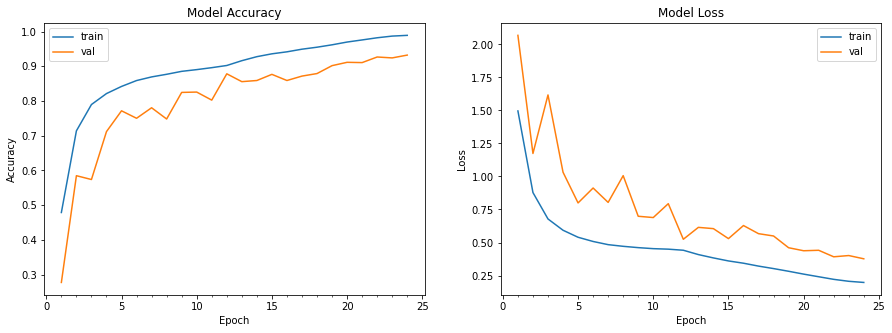

In [37]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# plot model history
plot_model_history(history)

# 4. Model with Original Batch Normalization Stride 8 - 30 epochs

## Network Architecture (ResNet 9)

In [0]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
def Resnet9(input_dim, n_classes): 
    inputs = Input(shape= input_dim, name='input')

    # Define the repeated conv_bn_relu function
    def conv_bn_relu(x, layer_name, pool=False):
        channels = {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 256}
        x = Conv2D(filters = channels[layer_name], 
                   kernel_size = 3, 
                   strides = 1, 
                   padding = 'same',
                   kernel_initializer=init_pytorch,
                   kernel_regularizer=l2(hparams['decay']),
                   use_bias=False)(x)
        # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        # Applying MODIFIED Batch Normalization with stride 8
        x = BatchNorm(stride=8)(x)
        x = ReLU()(x)
        if pool==True:
            x = MaxPooling2D(2)(x)
        return x        

    # Stack the layers
    # Layer Prep
    layer_prep = conv_bn_relu(inputs, 'prep')

    # Layer 1
    layer1_part1 = conv_bn_relu(layer_prep, 'layer1', pool=True)  
    layer1_part2_res1 = conv_bn_relu(layer1_part1, 'layer1')
    layer1_part2_res2 = conv_bn_relu(layer1_part2_res1, 'layer1')
    layer1 = Add()([layer1_part1, layer1_part2_res2])
    
    # Layer 2
    layer2_part1 = conv_bn_relu(layer1, 'layer2', pool=True)  
    layer2_part2_res1 = conv_bn_relu(layer2_part1, 'layer2')
    layer2_part2_res2 = conv_bn_relu(layer2_part2_res1, 'layer2')
    layer2 = Add()([layer2_part1, layer2_part2_res2])

    # Layer 3
    layer3 = conv_bn_relu(layer2, 'layer3', pool=True)

    # Layer Classifier
    layer_classifier = GlobalMaxPool2D()(layer3)
    layer_classifier = Flatten()(layer_classifier)
    layer_classifier = Dense(n_classes, kernel_initializer= init_pytorch,
                           kernel_regularizer=l2(hparams['decay']),
                           use_bias=False, name='classifier')(layer_classifier)
    layer_classifier = Lambda(lambda x : x * 0.2)(layer_classifier)

    outputs = Softmax()(layer_classifier)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr= hparams['learning_rate'], momentum= hparams['momentum'], 
                              nesterov=True),
                metrics=['accuracy'])
    return model

In [40]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_norm_32 (BatchNorm)       (None, 32, 32, 64)   256         conv2d_32[0][0]                  
__________________________________________________________________________________________________
re_lu_32 (ReLU)                 (None, 32, 32, 64)   0           batch_norm_32[0][0]              
____________________________________________________________________________________________

## Model Training

In [41]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel_MBN_S8.h5", verbose=0, 
                               save_best_only=True, monitor="val_accuracy")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams['learning_rate'],
                        batch_size = hparams['batch_size'],
                        samples = len(X_train),
                        epochs = hparams['n_epochs'],
                        maximum_momentum = hparams['momentum'],
                        verbose=False)

log_dir = "logs/fit/MBN_S8/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1,
                                                      profile_batch = '49')

# Fit the model
history = net.fit(datagen.flow(X_train, y_train, 
                  batch_size= hparams['batch_size'], 
                  shuffle=True),
                  epochs = hparams['n_epochs'], 
                  steps_per_epoch= np.ceil(X_train.shape[0]/hparams['batch_size']),
                  validation_data=(X_test, y_test),
                  callbacks = [lr_manager, checkpointer, tensorboard_callback])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/24
98/98 [==============================] - 12s 122ms/step - loss: 1.4809 - accuracy: 0.4893 - val_loss: 2.0894 - val_accuracy: 0.2927
Epoch 2/24
98/98 [==============================] - 12s 119ms/step - loss: 0.8803 - accuracy: 0.7125 - val_loss: 1.2490 - val_accuracy: 0.5739
Epoch 3/24
98/98 [==============================] - 12s 118ms/step - loss: 0.6897 - accuracy: 0.7845 - val_loss: 1.1067 - val_accuracy: 0.6449
Epoch 4/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5974 - accuracy: 0.8180 - val_loss: 0.9463 - val_accuracy: 0.7136
Epoch 5/24
98/98 [==============================] - 12s 118ms/step - loss: 0.5479 - accuracy: 0.8399 - val_loss: 1.0821 - val_accuracy: 0.6980
Epoch 6/24
98/98 [==============================] - 12s 119ms/step - loss: 0.5100 - accuracy: 0.8556 - val_loss: 0.9225 - val_accuracy: 0.7500
Epoch 7/24
98/98 [==============================] - 12s 118ms/step - loss: 0.4947 - accuracy: 0.8639 - val_loss: 0.8193 - val_accuracy: 0.7828

## Model Evaluation

In [42]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel_MBN_S8.h5", custom_objects={'init_pytorch': init_pytorch,
                                                              'BatchNorm': BatchNorm})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams['batch_size'], verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

20/20 [==============================] - 1s 29ms/step - loss: 0.3686 - accuracy: 0.9324
Minimal Validation Loss :  0.3685568869113922
Max Validation Accuracy: 93.23999881744385 %


## Tensorboard

In [0]:
%tensorboard --logdir logs/fit/MBN_S8/

## Plot Loss and Accuracy History

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


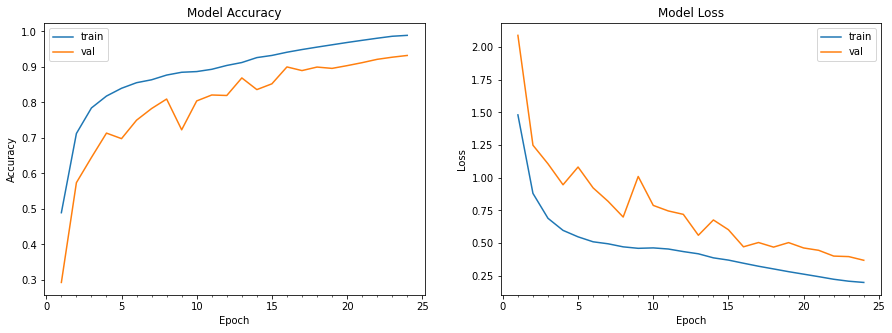

In [44]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# plot model history
plot_model_history(history)

# Download files and folders

In [45]:
!zip -r /content/logs_MBN.zip /content/logs

from google.colab import files
files.download("/content/logs_MBN.zip")

  adding: content/logs/ (stored 0%)
  adding: content/logs/fit/ (stored 0%)
  adding: content/logs/fit/MBN_S4/ (stored 0%)
  adding: content/logs/fit/MBN_S4/20200608-130219/ (stored 0%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/ (stored 0%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/plugins/ (stored 0%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/plugins/profile/ (stored 0%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/plugins/profile/2020_06_08_13_02_26/ (stored 0%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/plugins/profile/2020_06_08_13_02_26/1e5e32eb4707.input_pipeline.pb (deflated 58%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/plugins/profile/2020_06_08_13_02_26/1e5e32eb4707.tensorflow_stats.pb (deflated 77%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/plugins/profile/2020_06_08_13_02_26/1e5e32eb4707.kernel_stats.pb (deflated 96%)
  adding: content/logs/fit/MBN_S4/20200608-130219/train/plugins/